# Phân Loại TDE MALLORN - Khám Phá Dữ Liệu (V1)

**Mục tiêu của notebook:**
- Hiểu rõ phân bố lớp dữ liệu (TDE vs non-TDE)
- Phân tích phân bố redshift và extinction
- Quan sát đặc điểm lightcurve của các loại thiên thể
- Đánh giá độ phủ và tần suất quan sát theo từng băng sóng

**Key insights cho feature engineering:**
- TDE có màu xanh (strong u-band)
- TDE kéo dài lâu (~400+ days)
- Cần xử lý class imbalance nghiêm trọng

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
DATA_DIR = Path('../mallorn-astronomical-classification-challenge')

## 1. Tải Metadata

Đọc các file log để hiểu cấu trúc cơ bản của bộ dữ liệu huấn luyện và kiểm thử.

In [2]:
train_log = pd.read_csv(DATA_DIR / 'train_log.csv')
test_log = pd.read_csv(DATA_DIR / 'test_log.csv')

print(f"Training samples: {len(train_log)}")
print(f"Test samples: {len(test_log)}")
print(f"\nTraining columns: {train_log.columns.tolist()}")
print(f"Test columns: {test_log.columns.tolist()}")

Training samples: 3043
Test samples: 7135

Training columns: ['object_id', 'Z', 'Z_err', 'EBV', 'SpecType', 'English Translation', 'split', 'target']
Test columns: ['object_id', 'Z', 'Z_err', 'EBV', 'SpecType', 'English Translation', 'split']


## 2. Phân Bố Lớp

**Quan sát quan trọng:** Tỉ lệ class imbalance khoảng 19.6:1 (Non-TDE:TDE). Điều này yêu cầu:
- Sử dụng `scale_pos_weight` trong LightGBM
- Tối ưu hóa threshold dựa trên F1 score thay vì accuracy
- Có thể cần techniques như SMOTE hoặc class weighting


=== Class Distribution ===
target
0    2895
1     148
Name: count, dtype: int64

TDE ratio: 0.0486


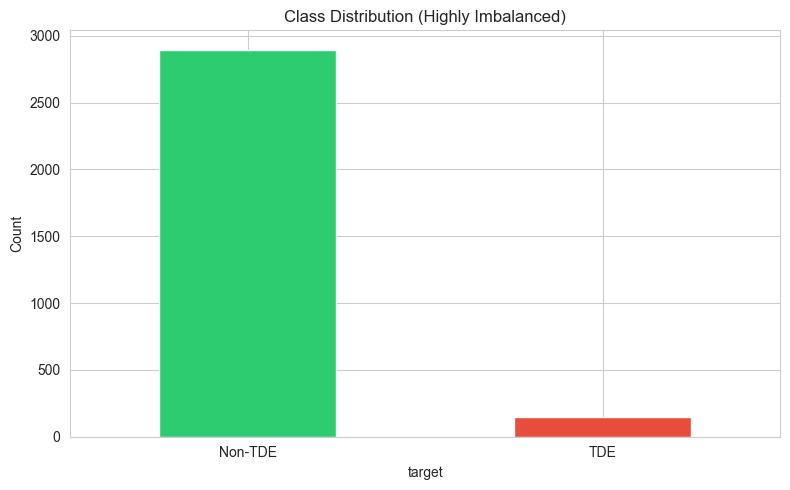


Class imbalance ratio: 19.6:1


In [3]:
print("\n=== Class Distribution ===")
print(train_log['target'].value_counts())
print(f"\nTDE ratio: {train_log['target'].mean():.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
train_log['target'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_xticklabels(['Non-TDE', 'TDE'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Highly Imbalanced)')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass imbalance ratio: {(1-train_log['target'].mean()) / train_log['target'].mean():.1f}:1")

## 3. Phân Bố Redshift

**Paper insight:** Hầu hết TDE của LSST sẽ ở redshift cao hơn (z > 0.1), do đó:
- Redshift là một feature quan trọng
- TDE ở z cao khó phát hiện hơn (flux yếu hơn, time dilation)

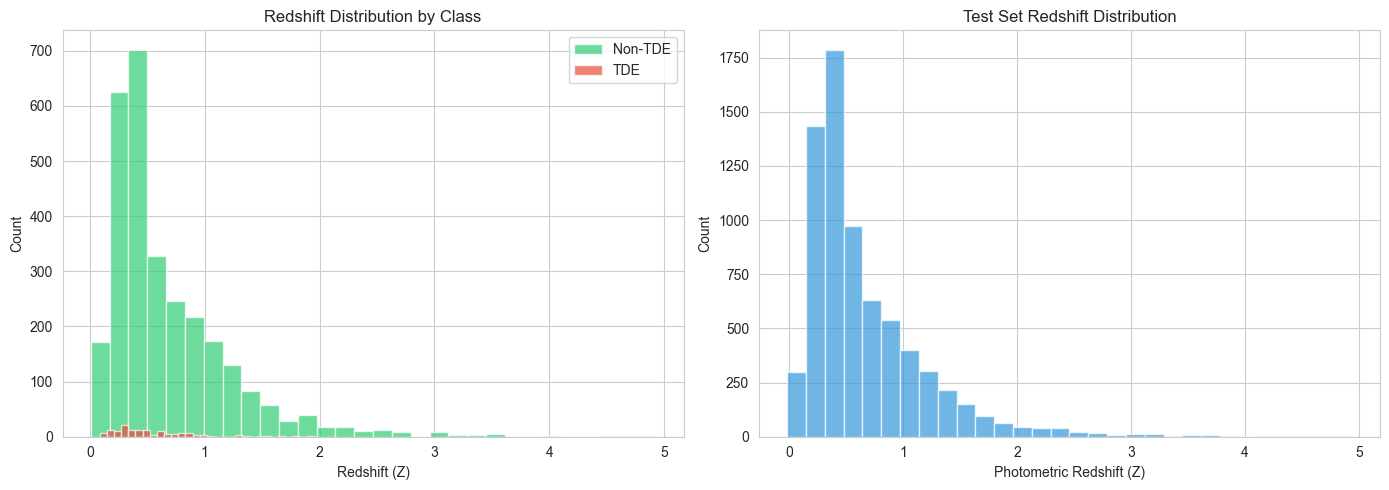


Train redshift - Mean: 0.671, Median: 0.482
Test redshift - Mean: 0.672, Median: 0.484


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_log[train_log['target']==0]['Z'], bins=30, alpha=0.7, label='Non-TDE', color='#2ecc71')
axes[0].hist(train_log[train_log['target']==1]['Z'], bins=30, alpha=0.7, label='TDE', color='#e74c3c')
axes[0].set_xlabel('Redshift (Z)')
axes[0].set_ylabel('Count')
axes[0].set_title('Redshift Distribution by Class')
axes[0].legend()

axes[1].hist(test_log['Z'], bins=30, alpha=0.7, color='#3498db')
axes[1].set_xlabel('Photometric Redshift (Z)')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set Redshift Distribution')

plt.tight_layout()
plt.savefig('redshift_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTrain redshift - Mean: {train_log['Z'].mean():.3f}, Median: {train_log['Z'].median():.3f}")
print(f"Test redshift - Mean: {test_log['Z'].mean():.3f}, Median: {test_log['Z'].median():.3f}")

## Load Sample Lightcurves

## 4. Tải Dữ Liệu Lightcurve Mẫu

Lightcurve chứa các quan sát flux theo thời gian và qua 6 filters: u, g, r, i, z, y

## Lightcurve Statistics

## 5. Thống Kê Lightcurve

**Quan sát về số lượng observations:**
- r, i, z bands có nhiều observations nhất
- u, y bands có ít observations nhất (nhưng u-band rất quan trọng cho TDE!)

**Về Flux:**
- ~39% flux âm → noise/non-detection
- Detection threshold: SNR > 5 (theo paper)

## Visualize Sample TDE and Non-TDE Lightcurves

Key from paper: TDEs are blue (strong u-band), long-lasting (400+ days)

## 6. Trực Quan Hóa Lightcurves Mẫu: TDE vs Non-TDE

**Mục tiêu:** Quan sát đặc điểm hình dạng lightcurve để xác định các features phân biệt:
- **TDE**: Blue (strong u-band), kéo dài lâu (~400 days), smooth evolution
- **AGN**: Stochastic variability, không có pattern rõ ràng
- **SN**: Rise and decay nhanh (~100-150 days), có thể không blue

## Key Insights for Feature Engineering

From paper analysis:
1. **TDEs are blue**: Strong u-band signal, high u-r and u-i colors
2. **Long duration**: TDEs last 400+ days (vs SNe ~100-150 days)
3. **Smooth evolution**: Less variability than AGN
4. **Peak characteristics**: Slower rise/decay than SNe
5. **Class imbalance**: Need proper handling (scale_pos_weight)
6. **Redshift matters**: Higher z TDEs harder to detect
7. **Band importance**: u, g, r most useful; z, y less coverage

## 7. Tổng Kết - Insights Chính Cho Feature Engineering

**Từ phân tích dữ liệu, chúng ta xác định được:**

1. **Class Imbalance nghiêm trọng** (~20:1)
   - Cần scale_pos_weight
   - Tối ưu threshold dựa trên F1

2. **Đặc điểm TDE quan trọng:**
   - **Blue color**: Strong u-band, high u-r và u-i colors
   - **Long duration**: 400+ days (vs SNe ~100-150 days)
   - **Smooth evolution**: Ít variability hơn AGN
   - **Slow rise/decay**: Chậm hơn SNe

3. **Band importance:**
   - **u, g, r** quan trọng nhất (TDE signature)
   - z, y có ít coverage hơn

4. **Features cần trích xuất:**
   - Color features (u-g, u-r, u-i)
   - Temporal features (duration, rise time, decay time)
   - Statistical features (variability, smoothness)
   - Detection counts per band

**Bước tiếp theo:** Feature Engineering (notebook 01_feature_engineering.ipynb)